# HNSCC

First we import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from umap import UMAP
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN

Then we load the CSV file

In [2]:
all_data = pd.read_table('./HNSCC_all_data.txt', header=None, low_memory=False)

# data contains only the expression levels
data = pd.DataFrame(all_data.values[6:,1:], columns=all_data.values[0, 1:], dtype=np.float32)
# here we transpose the matrix so that we have the genes on the columns and the cells on the rows
data = data.T

## Dimensionality reduction with UMAP

Since our data has to many columns(genes) to be plot and clustered we perform dimensionality reduction on it

In [3]:
reducer = UMAP(
    random_state=47,
    n_neighbors=20,
)
trans = reducer.fit_transform(data.values) # it's a numpy.ndarray
trans.shape # (5902, 2)

(5902, 2)

Text(0.5, 1.0, 'UMAP applied on HNSCC')

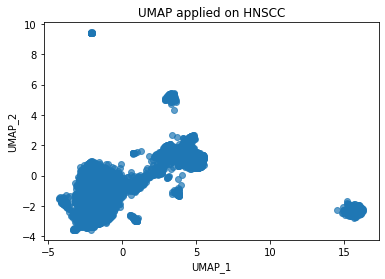

In [4]:
plt.scatter(
    trans[:, 0], # first column as X
    trans[:, 1], # second column as Y
    alpha=.7
)
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.title("UMAP applied on HNSCC")

## Clustering

We are going to use DBSCAN to find the clusters

In [5]:
db = DBSCAN().fit(trans)

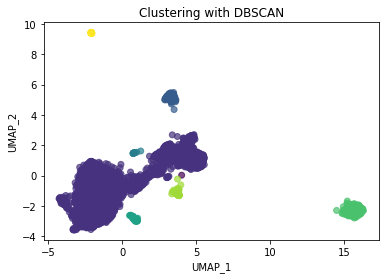

In [6]:
plt.scatter(
    trans[:, 0],
    trans[:, 1],
    alpha=.7,
    c=db.labels_
)
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.title("Clustering with DBSCAN");

In [7]:
def plot_cluster(n):
    cluster_mask = db.labels_.astype(np.int32) == 9999999
    if type(n) != list:
        cluster_mask = db.labels_.astype(np.int32) == n
    else:
        for c in n:
            cluster_mask |= db.labels_.astype(np.int32) == c
    
    plt.scatter(
        trans[cluster_mask, 0],
        trans[cluster_mask, 1],
        alpha=.7,
        c=db.labels_[cluster_mask]
    )
    plt.xlabel("UMAP_1")
    plt.ylabel("UMAP_2")
    plt.xlim(np.amin(trans[:, 0]) - 1, np.amax(trans[:, 0] + 1))
    plt.ylim(np.amin(trans[:, 1]) - 1, np.amax(trans[:, 1] + 1))
    plt.title("Cluster " + str(n));
    plt.show()

## Find the most expressed genes for each cluster

In [8]:
import scanpy as sc

In [9]:
sc.set_figure_params(dpi_save=300)

In [10]:
data.columns = all_data.iloc[6:, 0].values

In [11]:
ld = pd.DataFrame(db.labels_[db.labels_!=-1], index=data.index[db.labels_!=-1], columns=["cluster"])
ld["cluster"] = ld.cluster.astype('category')

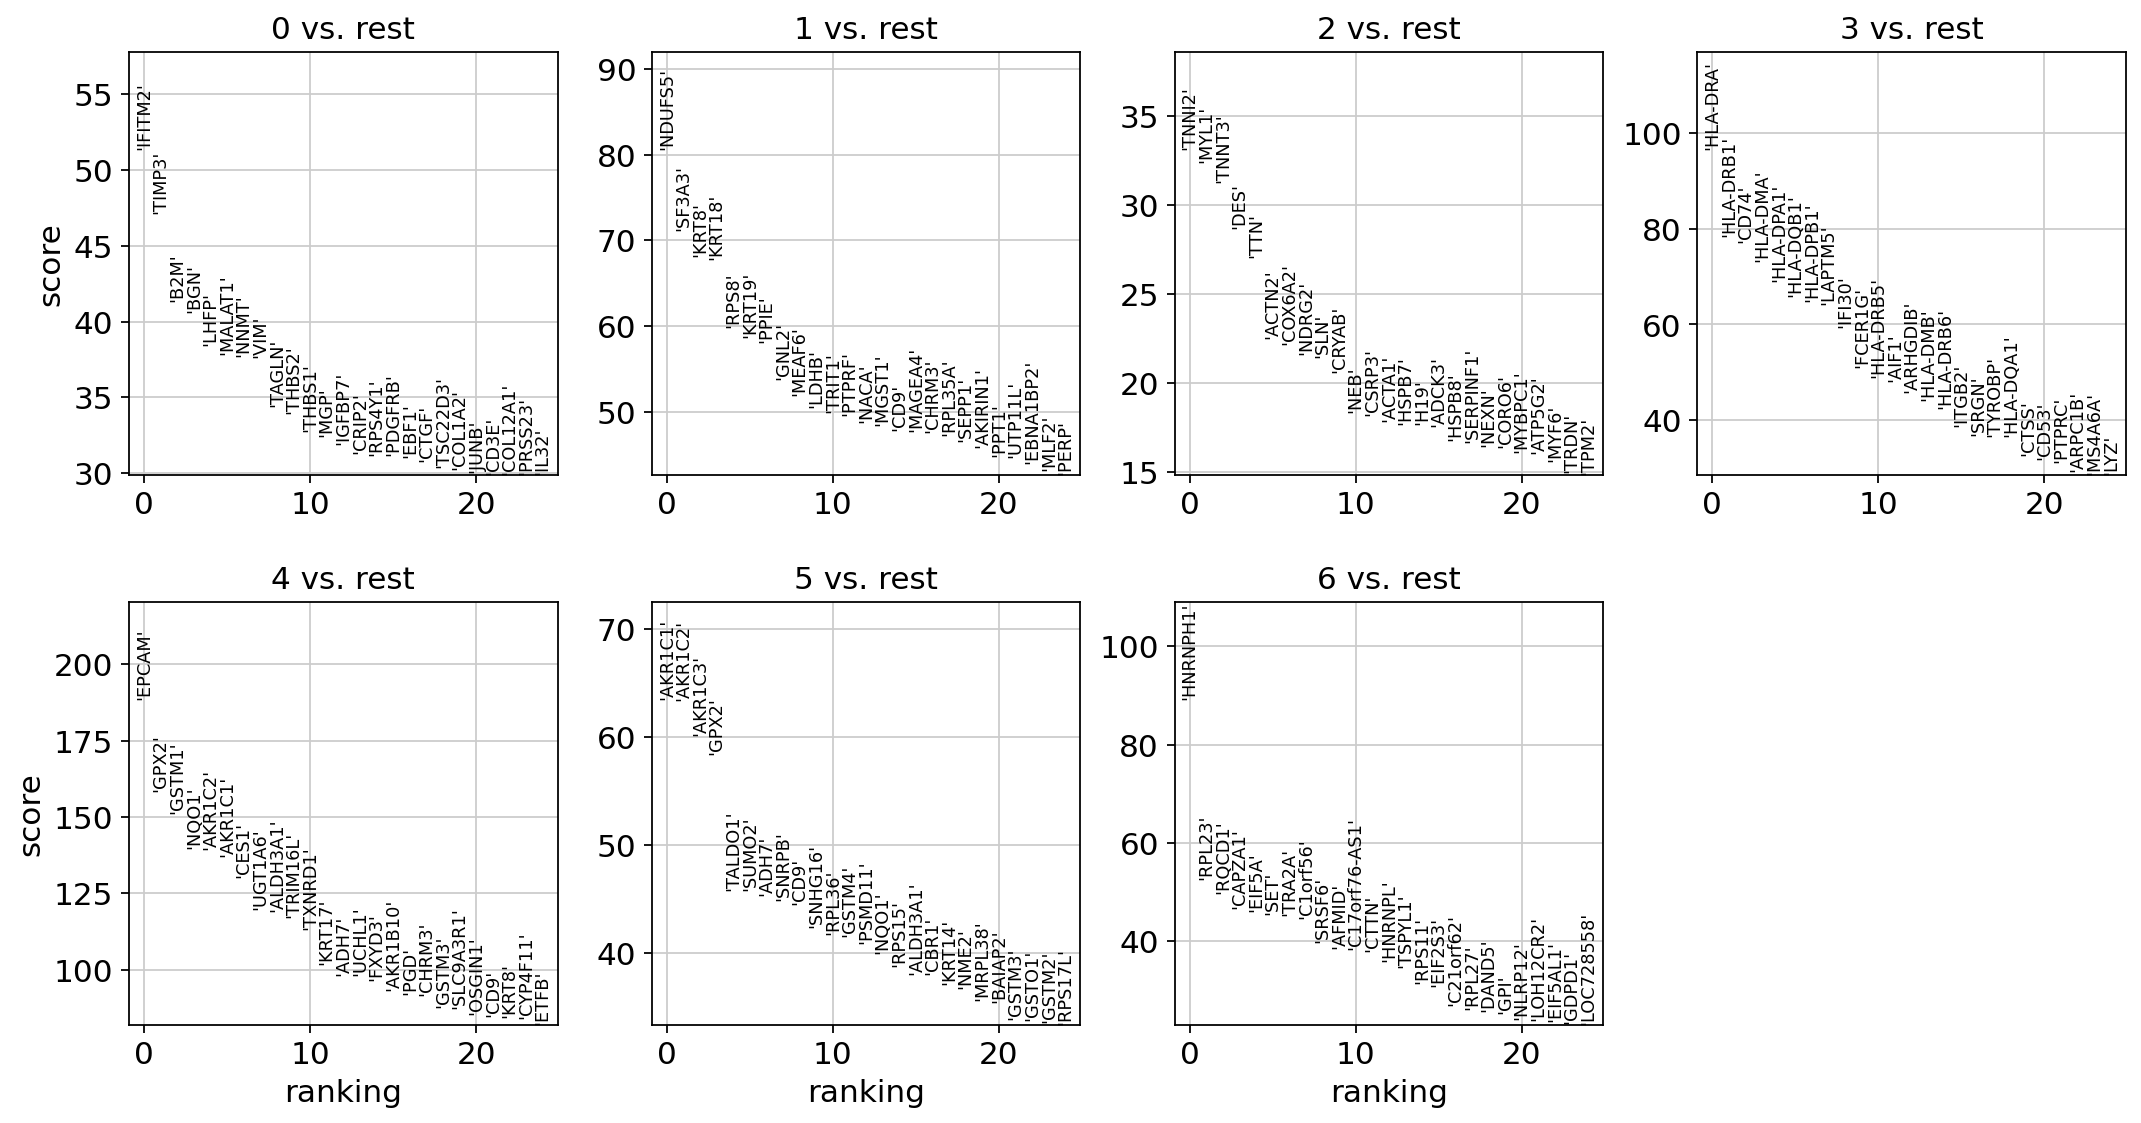

In [12]:
adata = sc.AnnData(data.iloc[db.labels_!=-1, :], ld)
sc.tl.rank_genes_groups(adata, 'cluster', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, figsize=(10,10), save="HNSCC_cluster_most_expr_genes.png")

In [13]:
cluster_count = len(set(db.labels_)) - abs(db.labels_[db.labels_==-1].sum())
for cluster_id in range(0, cluster_count):
    most_six = []
    for gene_id in range(0, 12):
        most_six.append(adata.uns["rank_genes_groups"]["names"][gene_id][cluster_id][1:-1])
    print(cluster_id, most_six)

0 ['IFITM2', 'TIMP3', 'B2M', 'BGN', 'LHFP', 'MALAT1', 'NNMT', 'VIM', 'TAGLN', 'THBS2', 'THBS1', 'MGP']
1 ['NDUFS5', 'SF3A3', 'KRT8', 'KRT18', 'RPS8', 'KRT19', 'PPIE', 'GNL2', 'MEAF6', 'LDHB', 'TRIT1', 'PTPRF']
2 ['TNNI2', 'MYL1', 'TNNT3', 'DES', 'TTN', 'ACTN2', 'COX6A2', 'NDRG2', 'SLN', 'CRYAB', 'NEB', 'CSRP3']
3 ['HLA-DRA', 'HLA-DRB1', 'CD74', 'HLA-DMA', 'HLA-DPA1', 'HLA-DQB1', 'HLA-DPB1', 'LAPTM5', 'IFI30', 'FCER1G', 'HLA-DRB5', 'AIF1']
4 ['EPCAM', 'GPX2', 'GSTM1', 'NQO1', 'AKR1C2', 'AKR1C1', 'CES1', 'UGT1A6', 'ALDH3A1', 'TRIM16L', 'TXNRD1', 'KRT17']
5 ['AKR1C1', 'AKR1C2', 'AKR1C3', 'GPX2', 'TALDO1', 'SUMO2', 'ADH7', 'SNRPB', 'CD9', 'SNHG16', 'RPL36', 'GSTM4']
6 ['HNRNPH1', 'RPL23', 'RQCD1', 'CAPZA1', 'EIF5A', 'SET', 'TRA2A', 'C1orf56', 'SRSF6', 'AFMID', 'C17orf76-AS1', 'CTTN']


## Show gene expression 

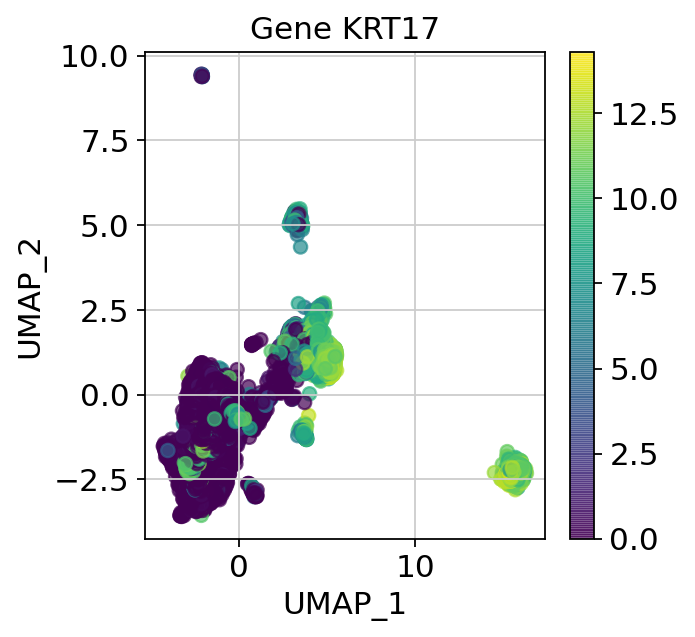

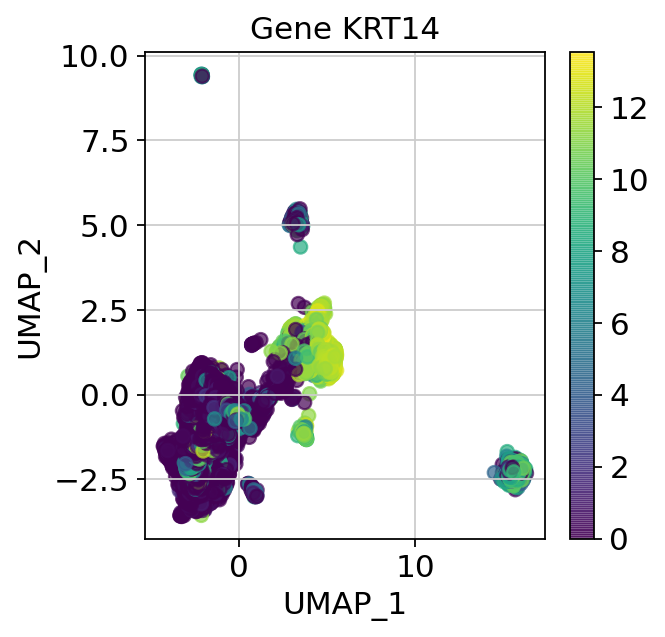

In [14]:
def plot_gene(gene_number, gene_name):
    plt.scatter(
        trans[:, 0],
        trans[:, 1],
        alpha=.7,
        c=data.values[:, gene_number].astype(np.float32)
    )
    plt.xlabel("UMAP_1")
    plt.ylabel("UMAP_2")
    plt.title("Gene " + gene_name);
    plt.colorbar()
    plt.show()

plot_gene(21035, "KRT17")
plot_gene(19983, "KRT14") 

# Cancer labels - ground truth

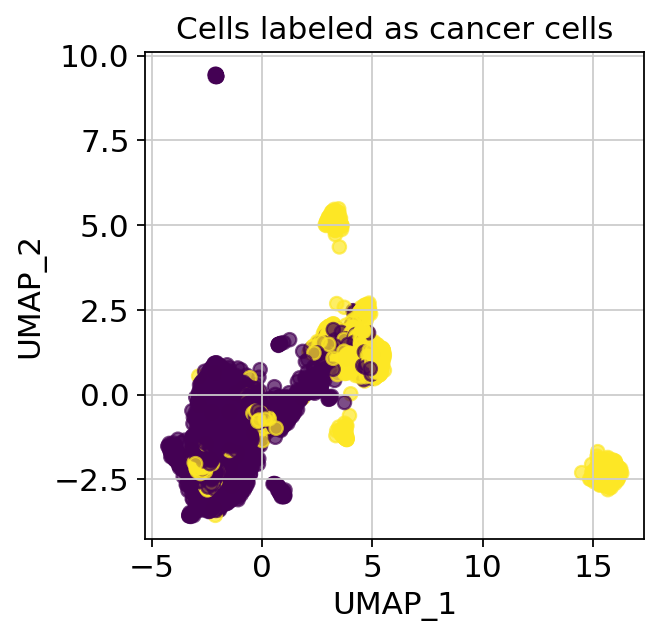

In [15]:
plt.scatter(
    trans[:, 0],
    trans[:, 1],
    alpha=.7,
    c=all_data.values[3, 1:].astype(np.int32)
)
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.title("Cells labeled as cancer cells");

## Get most expressed genes for cancer and non-cancer cells

In [16]:
label_cancer = all_data.values[3, 1:].astype(np.int32)

def most_expr_genes(is_cancer):
    is_cancer = int(is_cancer)
    cancer_cells = data.iloc[label_cancer == is_cancer, :]
    sorted_cancer_genes = cancer_cells.sum(axis=0).sort_values() / cancer_cells.shape[0]

    # print the most expressed genes in the cancer cells
    if(is_cancer == 1):
        print("Most expressed genes for cancer cells")
    else:
        print("Most expressed genes for non cancer cells")
    
    print(sorted_cancer_genes.tail(10))
    print("")


most_expr_genes(is_cancer=True)
most_expr_genes(is_cancer=False)

Most expressed genes for cancer cells
'MTRNR2L8'    8.858067
'FTL'         8.980808
'KRT14'       9.000530
'ACTB'        9.011829
'GAPDH'       9.163144
'ANXA2'       9.165284
'RPL7'        9.260674
'MTRNR2L2'    9.391273
'B2M'         9.411673
'KRT17'       9.459337
dtype: float32

Most expressed genes for non cancer cells
'UBB'          7.869514
'RPL7'         8.164022
'FTL'          8.200986
'MALAT1'       8.220915
'MTRNR2L8'     8.420489
'FTH1'         8.525080
'ACTB'         9.071202
'MTRNR2L2'     9.172549
'TMSB4X'       9.881761
'B2M'         11.214761
dtype: float32



## Cluster size

In [17]:
cluster_count = len(set(db.labels_)) - abs(db.labels_[db.labels_==-1].sum())
for cluster_id in range(0, cluster_count):
    cluster_mask = db.labels_.astype(np.int32) == cluster_id
    print("Cluster " + str(cluster_id) + ":", data.iloc[cluster_mask].shape[0])

Cluster 0: 4839
Cluster 1: 226
Cluster 2: 12
Cluster 3: 89
Cluster 4: 597
Cluster 5: 109
Cluster 6: 29
